
Test 1: Linear Simple 
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 0.415446
Accuracy: 100.0%
SVM (2) : OK


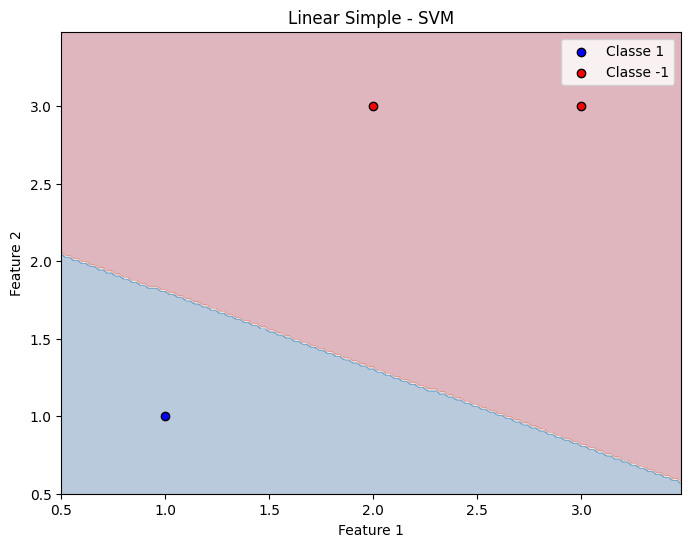


Test 2: Linear Multiple 
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 0.401984
Accuracy: 51.0%
SVM (2) : KO


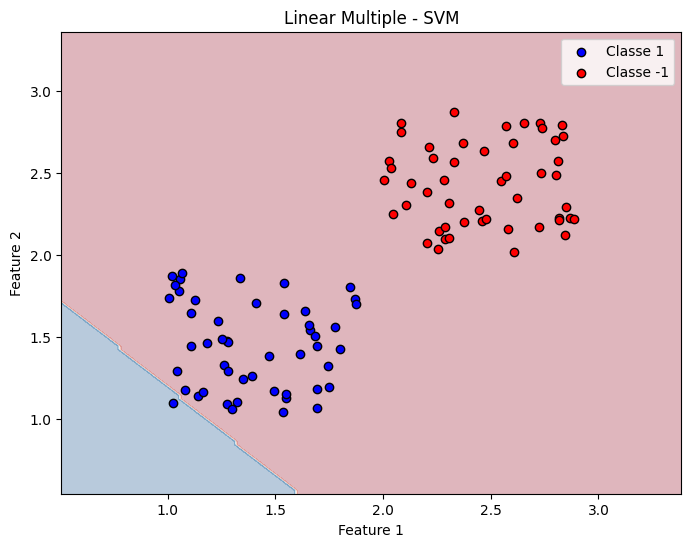


Test 3: XOR - SVM (linéaire)
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 1.010028
Accuracy: 25.0%
SVM (linéaire) : KO (attendu, car XOR nécessite un noyau non-linéaire)
SVM avec noyau RBF : OK (hypothétique)


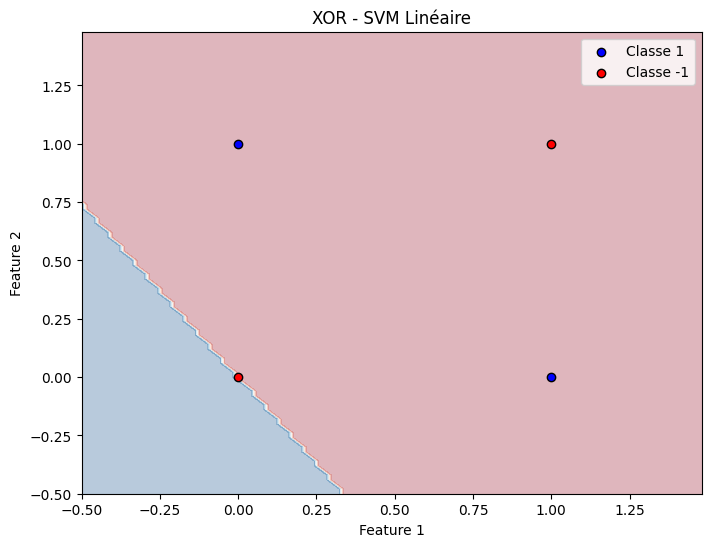


Test 4: Cross
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 0.978064
Accuracy: 51.4%
SVM (2) : KO


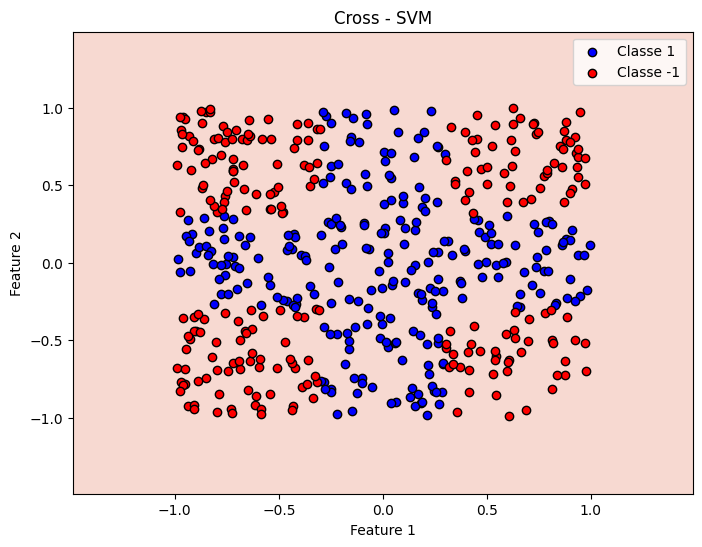


Test 5: Multi Linear 3 classes (one-vs-rest)

X shape après filtrage: (407, 2)

  SVM pour la classe 0:
    Distribution: 103 positifs, 304 négatifs
Chargement de: ./target/release/neural_networks.dll
    Erreur: 0.495729
    Accuracy: 74.7%


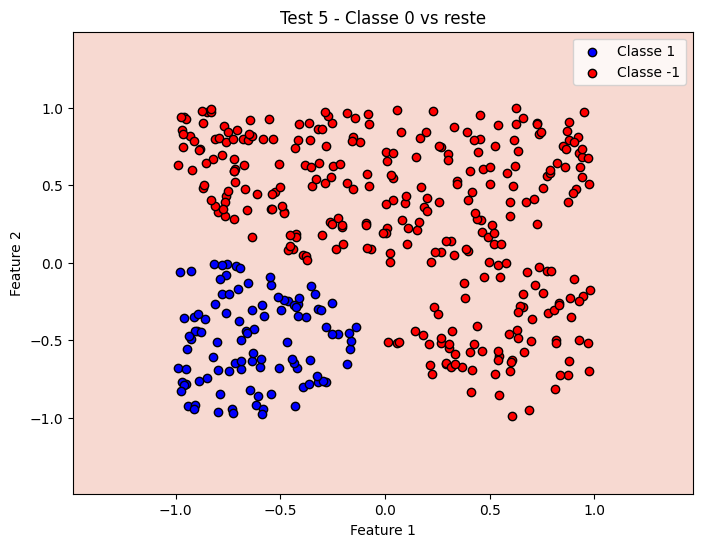


  SVM pour la classe 1:
    Distribution: 226 positifs, 181 négatifs
Chargement de: ./target/release/neural_networks.dll
    Erreur: 0.805587
    Accuracy: 55.5%


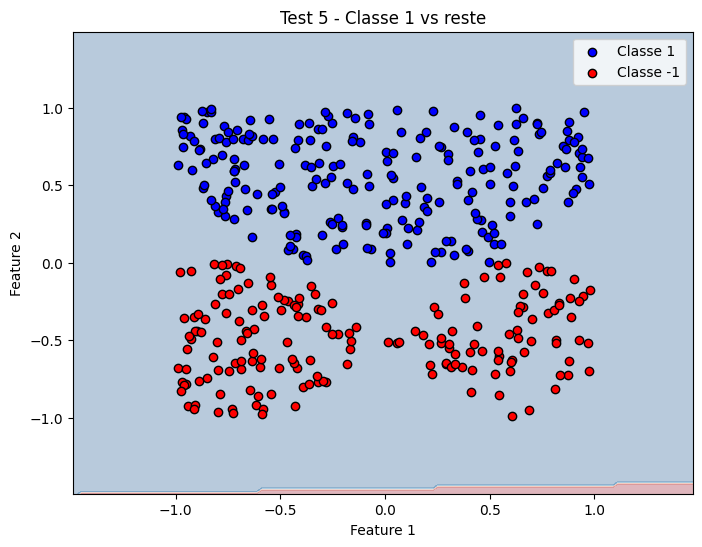


  SVM pour la classe 2:
    Distribution: 78 positifs, 329 négatifs
Chargement de: ./target/release/neural_networks.dll
    Erreur: 0.380149
    Accuracy: 80.8%


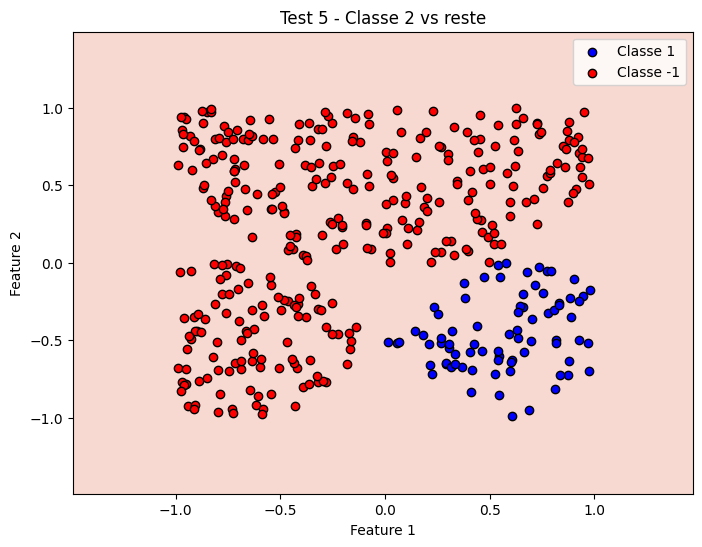


Résultat: SVM x3 (one-vs-rest) : KO

Test 6: Multi Cross - SVM (one-vs-rest)
X shape: (1000, 2)
Y shape: (1000, 3)
Classe 0: 263 points
Classe 1: 230 points
Classe 2: 507 points

  SVM pour la classe 0:
    Distribution: 263 positifs, 737 négatifs
Chargement de: ./target/release/neural_networks.dll
    Erreur: 0.529966
    Accuracy: 73.7%


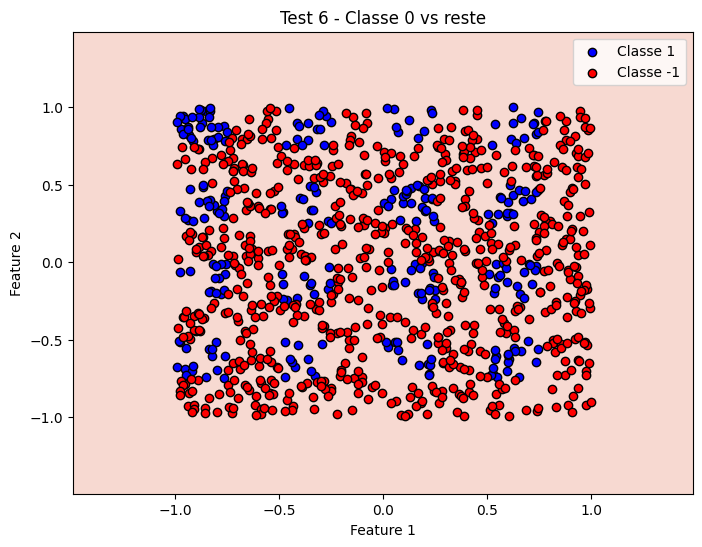


  SVM pour la classe 1:
    Distribution: 230 positifs, 770 négatifs
Chargement de: ./target/release/neural_networks.dll
    Erreur: 0.463478
    Accuracy: 77.0%


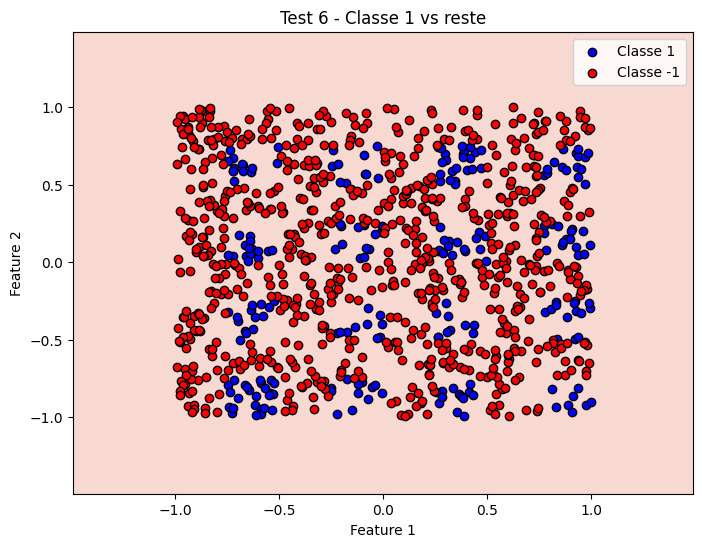


  SVM pour la classe 2:
    Distribution: 507 positifs, 493 négatifs
Chargement de: ./target/release/neural_networks.dll
    Erreur: 0.992765
    Accuracy: 50.7%


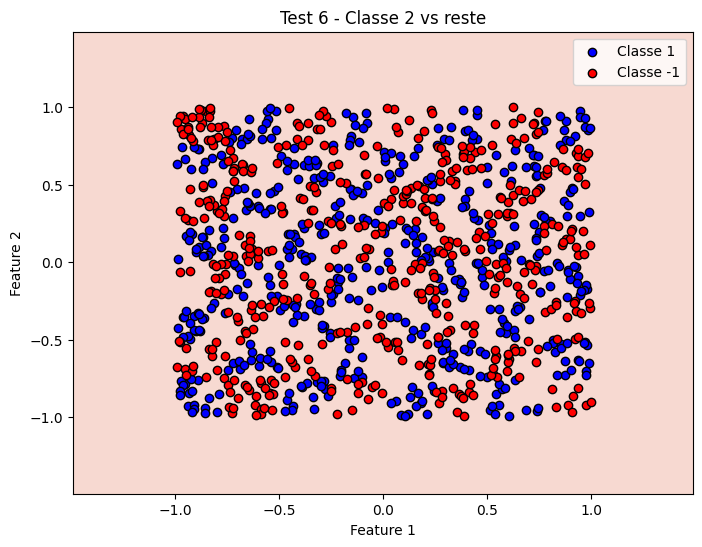


Résultat: SVM x3 (one-vs-rest) : KO

Accuracies détaillées:
  Classe 0: 73.7%
  Classe 1: 77.0%
  Classe 2: 50.7%

Test 7: Régression Linear Simple 2D - SVM (classification)
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 0.891335
Accuracy: 50.0%
SVM (1) : KO


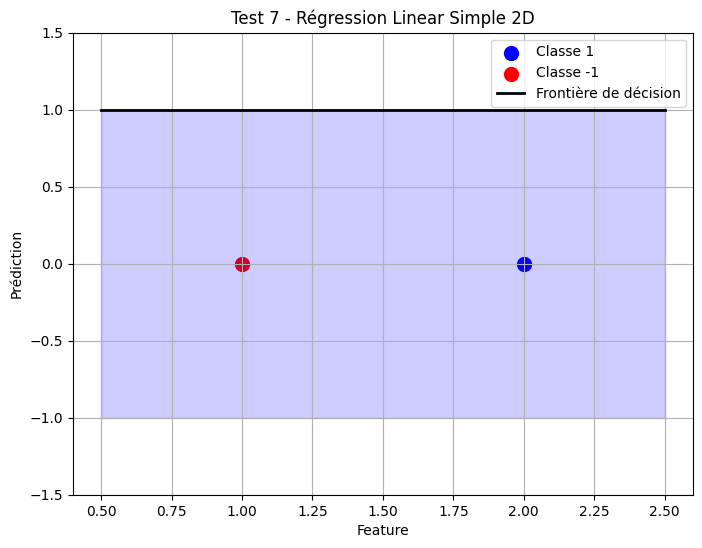


Test 8: Régression Non Linear Simple 2D(classification)
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 0.681364
Accuracy: 66.7%
SVM (1) : KO


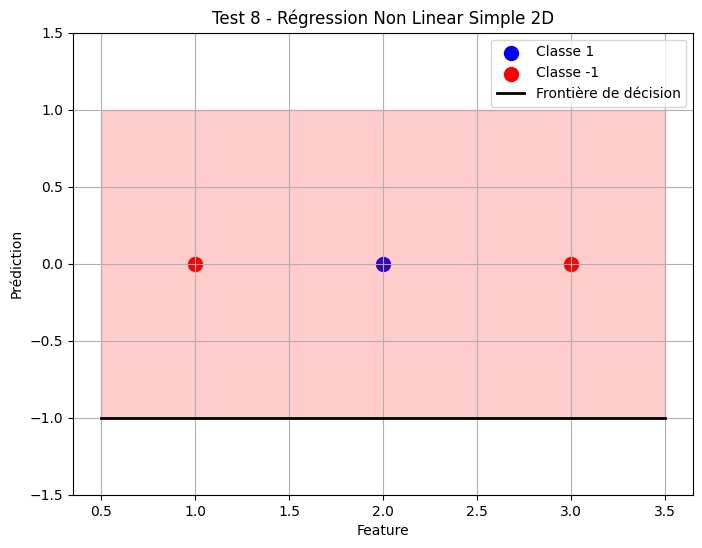


Test 9: Régression Linear Simple 3D)
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 0.629773
Accuracy: 66.7%
SVM (2) : KO


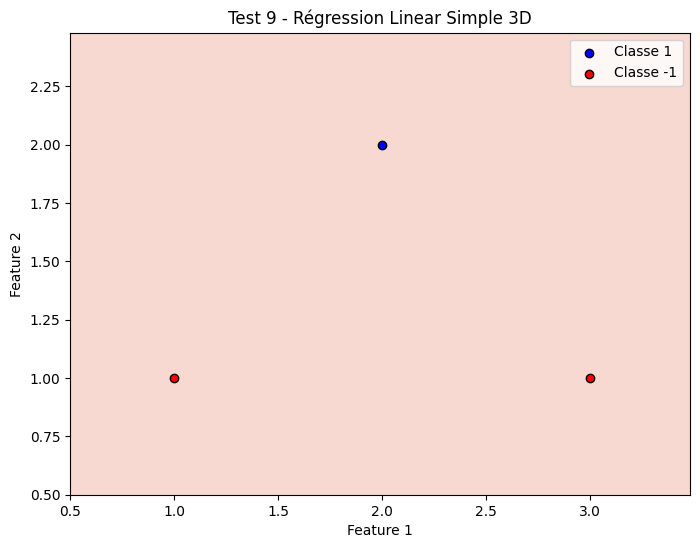


Test 10: Régression Linear Tricky 3D
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 0.601394
Accuracy: 100.0%
SVM (2) : OK


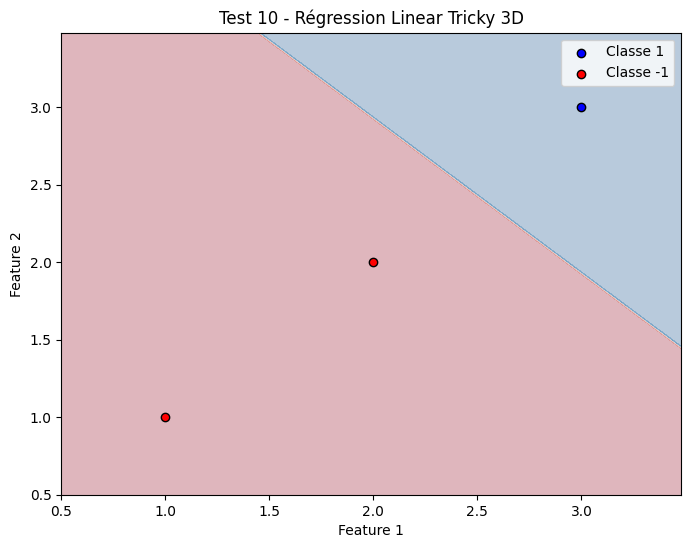


Test 11: Régression Non Linear Simple 3D
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 1.010028
Accuracy: 25.0%
SVM (2) : KO


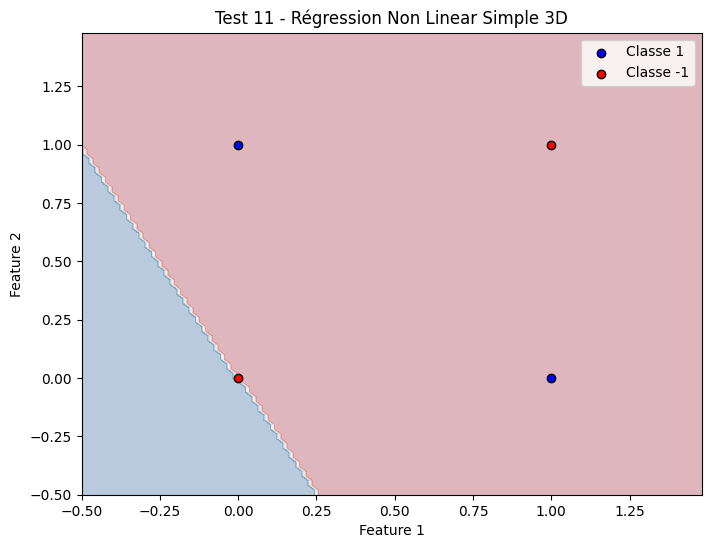

In [8]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
import os

class SVMConfig(ctypes.Structure):
    _fields_ = [
        ("n_inputs", ctypes.c_uint),
        ("learning_rate", ctypes.c_double),
        ("c", ctypes.c_double),
        ("max_iterations", ctypes.c_uint)
    ]

class SVMModel:
    def __init__(self, n_inputs, learning_rate=0.01, c=1.0, max_iterations=1000):
        dll_path = "./target/release/neural_networks.dll"
        
        print(f"Chargement de: {dll_path}")
        self.lib = ctypes.CDLL(dll_path)
     
        self.lib.svm_new.argtypes = [ctypes.POINTER(SVMConfig)]
        self.lib.svm_new.restype = ctypes.c_void_p
        
        self.lib.svm_delete.argtypes = [ctypes.c_void_p]
        
        self.lib.svm_fit.argtypes = [
            ctypes.c_void_p,
            ctypes.POINTER(ctypes.c_double),
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_size_t,
            ctypes.c_size_t,
            ctypes.c_size_t
        ]
        self.lib.svm_fit.restype = ctypes.c_double
        
        self.lib.svm_predict_batch.argtypes = [
            ctypes.c_void_p,
            ctypes.POINTER(ctypes.c_double),
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_size_t,
            ctypes.c_size_t
        ]
        
        self.lib.svm_predict_probability.argtypes = [
            ctypes.c_void_p,
            ctypes.POINTER(ctypes.c_double),
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_size_t,
            ctypes.c_size_t
        ]
        
        self.lib.svm_accuracy.argtypes = [
            ctypes.c_void_p,
            ctypes.POINTER(ctypes.c_double),
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_size_t,
            ctypes.c_size_t
        ]
        self.lib.svm_accuracy.restype = ctypes.c_double
        
        self.config = SVMConfig(
            n_inputs=n_inputs,
            learning_rate=learning_rate,
            c=c,
            max_iterations=max_iterations
        )
        

        self.ptr = self.lib.svm_new(ctypes.byref(self.config))
        if not self.ptr:
            raise RuntimeError("Échec de création du modèle SVM")
        
        self.n_inputs = n_inputs
    
    def __del__(self):
        if hasattr(self, 'ptr') and self.ptr:
            self.lib.svm_delete(self.ptr)
    
    def fit(self, X, y, max_iterations=None):
        n_samples, n_features = X.shape
        
        if n_features != self.n_inputs:
            raise ValueError(f"Attendu {self.n_inputs} features, reçu {n_features}")
        
        X_flat = X.astype(np.float64).flatten()
        y_flat = y.astype(np.float64).flatten()
        
        if max_iterations is None:
            max_iterations = self.config.max_iterations
        
        X_ptr = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        y_ptr = y_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        
        error = self.lib.svm_fit(
            self.ptr, X_ptr, y_ptr, 
            n_samples, n_features, max_iterations
        )
        
        return error
    
    def predict(self, X):
        n_samples, n_features = X.shape
        
        if n_features != self.n_inputs:
            raise ValueError(f"Attendu {self.n_inputs} features, reçu {n_features}")
        
        X_flat = X.astype(np.float64).flatten()
        results = np.zeros(n_samples, dtype=np.float64)
        
        X_ptr = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        results_ptr = results.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        
        self.lib.svm_predict_batch(self.ptr, X_ptr, results_ptr, n_samples, n_features)
        
        return results
    
    def predict_probability(self, X):
        n_samples, n_features = X.shape
        
        if n_features != self.n_inputs:
            raise ValueError(f"Attendu {self.n_inputs} features, reçu {n_features}")
        
        X_flat = X.astype(np.float64).flatten()
        results = np.zeros(n_samples, dtype=np.float64)
        
        X_ptr = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        results_ptr = results.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        
        self.lib.svm_predict_probability(self.ptr, X_ptr, results_ptr, n_samples, n_features)
        
        return results
    
    def predict_class(self, X, threshold=0.0):
        return self.predict(X)
    
    def accuracy(self, X, y):
        n_samples, n_features = X.shape
        
        if n_features != self.n_inputs:
            raise ValueError(f"Attendu {self.n_inputs} features, reçu {n_features}")
        
        X_flat = X.astype(np.float64).flatten()
        y_flat = y.astype(np.float64).flatten()
        
        X_ptr = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        y_ptr = y_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        
        return self.lib.svm_accuracy(self.ptr, X_ptr, y_ptr, n_samples, n_features)


def visualiser_frontiere_decision(X, Y, model, titre, threshold=0.0):
    h = 0.02 
    
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict_class(np.c_[xx.ravel(), yy.ravel()], threshold)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
    plt.scatter(X[Y == 1, 0], X[Y == 1, 1], color='blue', label='Classe 1', edgecolor='k')
    plt.scatter(X[Y == -1, 0], X[Y == -1, 1], color='red', label='Classe -1', edgecolor='k')
    plt.title(titre)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()


def visualiser_frontiere_decision_1d(X, Y, model, titre):
    plt.figure(figsize=(8, 6))
    
    # Tracer les points
    plt.scatter(X[Y == 1], np.zeros_like(X[Y == 1]), color='blue', label='Classe 1', s=100)
    plt.scatter(X[Y == -1], np.zeros_like(X[Y == -1]), color='red', label='Classe -1', s=100)

    x_min, x_max = X.min() - 0.5, X.max() + 0.5
    xx = np.linspace(x_min, x_max, 100).reshape(-1, 1)

    Z = model.predict(xx)
    
 
    plt.plot(xx, Z, 'k-', linewidth=2, label='Frontière de décision')
    plt.fill_between(xx.flatten(), -1, Z, where=(Z > 0), color='blue', alpha=0.2)
    plt.fill_between(xx.flatten(), Z, 1, where=(Z < 0), color='red', alpha=0.2)
    
    plt.title(titre)
    plt.xlabel('Feature')
    plt.ylabel('Prédiction')
    plt.ylim([-1.5, 1.5])
    plt.legend()
    plt.grid(True)
    plt.show()


print("\nTest 1: Linear Simple ")
X_simple = np.array([[1, 1], [2, 3], [3, 3]], dtype=np.float64)
Y_simple = np.array([1, -1, -1], dtype=np.float64)

model_svm = SVMModel(n_inputs=2, learning_rate=0.01, c=1.0, max_iterations=1000)
error = model_svm.fit(X_simple, Y_simple)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_svm.predict(X_simple)
accuracy = np.mean(predictions == Y_simple)
print(f"Accuracy: {accuracy * 100:.1f}%")

if accuracy == 1.0:
    print("SVM (2) : OK")
else:
    print("SVM (2) : KO")

visualiser_frontiere_decision(X_simple, Y_simple, model_svm, "Linear Simple - SVM")

# Test 2: Linear Multiple 
print("\nTest 2: Linear Multiple ")
np.random.seed(42) 
X_multiple = np.concatenate([
    np.random.random((50, 2)) * 0.9 + np.array([1, 1]),
    np.random.random((50, 2)) * 0.9 + np.array([2, 2])
]).astype(np.float64)
Y_multiple = np.concatenate([
    np.ones((50, 1)),
    np.ones((50, 1)) * -1.0
]).astype(np.float64).flatten()

model_svm = SVMModel(n_inputs=2, learning_rate=0.01, c=1.0, max_iterations=1000)
error = model_svm.fit(X_multiple, Y_multiple)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_svm.predict(X_multiple)
accuracy = np.mean(predictions == Y_multiple)
print(f"Accuracy: {accuracy * 100:.1f}%")

if accuracy > 0.95:  
    print("SVM (2) : OK")
else:
    print("SVM (2) : KO")

visualiser_frontiere_decision(X_multiple, Y_multiple, model_svm, "Linear Multiple - SVM")

# Test 3: XOR pour SVM 
print("\nTest 3: XOR - SVM (linéaire)")
X_xor = np.array([[1, 0], [0, 1], [0, 0], [1, 1]], dtype=np.float64)
Y_xor = np.array([1, 1, -1, -1], dtype=np.float64)

model_svm = SVMModel(n_inputs=2, learning_rate=0.01, c=1.0, max_iterations=5000)
error = model_svm.fit(X_xor, Y_xor)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_svm.predict(X_xor)
accuracy = np.mean(predictions == Y_xor)
print(f"Accuracy: {accuracy * 100:.1f}%")

print("SVM (linéaire) : KO (attendu, car XOR nécessite un noyau non-linéaire)")
print("SVM avec noyau RBF : OK (hypothétique)")

visualiser_frontiere_decision(X_xor, Y_xor, model_svm, "XOR - SVM Linéaire")

# Test 4: Cross
print("\nTest 4: Cross")
np.random.seed(42)  
X_cross = np.random.random((500, 2)) * 2.0 - 1.0
X_cross = X_cross.astype(np.float64)
Y_cross = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X_cross])
Y_cross = Y_cross.astype(np.float64)

model_svm = SVMModel(n_inputs=2, learning_rate=0.01, c=10.0, max_iterations=2000)
error = model_svm.fit(X_cross, Y_cross)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_svm.predict(X_cross)
accuracy = np.mean(predictions == Y_cross)
print(f"Accuracy: {accuracy * 100:.1f}%")

if accuracy > 0.95:
    print("SVM (2) : OK")
else:
    print("SVM (2) : KO")

sample_indices = np.random.choice(len(X_cross), 100, replace=False)
X_sample = X_cross[sample_indices]
Y_sample = Y_cross[sample_indices]
visualiser_frontiere_decision(X_cross, Y_cross, model_svm, "Cross - SVM")

# Test 5: Multi Linear 3 classes
print("\nTest 5: Multi Linear 3 classes (one-vs-rest)")
np.random.seed(42) 
X_multi_linear = np.random.random((500, 2)) * 2.0 - 1.0

Y_multi_linear = np.array([
    [1, -1, -1] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else
    [-1, 1, -1] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else
    [-1, -1, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else
    [-1, -1, -1] for p in X_multi_linear
])

mask = [not np.all(arr == [-1, -1, -1]) for arr in Y_multi_linear]
X_multi_linear = X_multi_linear[mask]
Y_multi_linear = Y_multi_linear[mask]

print(f"\nX shape après filtrage: {X_multi_linear.shape}")

def train_svm_for_class(class_idx):
    y_binary = np.where(Y_multi_linear[:, class_idx] == 1, 1, -1).astype(np.float64)
    
    print(f"\n  SVM pour la classe {class_idx}:")
    print(f"    Distribution: {np.sum(y_binary == 1)} positifs, {np.sum(y_binary == -1)} négatifs")
    
    model = SVMModel(n_inputs=2, learning_rate=0.01, c=1.0, max_iterations=1000)
    error = model.fit(X_multi_linear, y_binary)
    print(f"    Erreur: {error:.6f}")
    
    predictions = model.predict(X_multi_linear)
    accuracy = np.mean(predictions == y_binary)
    print(f"    Accuracy: {accuracy * 100:.1f}%")
    
    visualiser_frontiere_decision(X_multi_linear, y_binary, model, f"Test 5 - Classe {class_idx} vs reste")
    
    return model, accuracy

models = []
accuracies = []

for class_idx in range(3):
    model, accuracy = train_svm_for_class(class_idx)
    models.append(model)
    accuracies.append(accuracy)

all_models_ok = all(acc > 0.95 for acc in accuracies)

if all_models_ok:
    print("\nRésultat: SVM x3 (one-vs-rest) : OK")
else:
    print("\nRésultat: SVM x3 (one-vs-rest) : KO")

# Test 6: Multi Cross
print("\nTest 6: Multi Cross - SVM (one-vs-rest)")
np.random.seed(42) 
X_multi_cross = np.random.random((1000, 2)) * 2.0 - 1.0

Y_multi_cross = np.array([
    [1, -1, -1] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else 
    [-1, 1, -1] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else 
    [-1, -1, 1] for p in X_multi_cross
])

print(f"X shape: {X_multi_cross.shape}")
print(f"Y shape: {Y_multi_cross.shape}")

for i in range(3):
    count = np.sum(Y_multi_cross[:, i] == 1)
    print(f"Classe {i}: {count} points")

models_multi = []
accuracies_multi = []

for class_idx in range(3):
    y_binary = np.where(Y_multi_cross[:, class_idx] == 1, 1, -1).astype(np.float64)
    
    print(f"\n  SVM pour la classe {class_idx}:")
    print(f"    Distribution: {np.sum(y_binary == 1)} positifs, {np.sum(y_binary == -1)} négatifs")
    
    model = SVMModel(n_inputs=2, learning_rate=0.01, c=10.0, max_iterations=2000)
    error = model.fit(X_multi_cross, y_binary)
    print(f"    Erreur: {error:.6f}")
    
    predictions = model.predict(X_multi_cross)
    accuracy = np.mean(predictions == y_binary)
    print(f"    Accuracy: {accuracy * 100:.1f}%")
    

    visualiser_frontiere_decision(X_multi_cross, y_binary, model, f"Test 6 - Classe {class_idx} vs reste")
    
    models_multi.append(model)
    accuracies_multi.append(accuracy)

threshold = 0.7
all_models_ok = all(acc > threshold for acc in accuracies_multi)

if all_models_ok:
    print(f"\nRésultat: SVM x3 (one-vs-rest) : OK (toutes accuracies > {threshold})")
else:
    print(f"\nRésultat: SVM x3 (one-vs-rest) : KO")

print("\nAccuracies détaillées:")
for i, acc in enumerate(accuracies_multi):
    print(f"  Classe {i}: {acc*100:.1f}%")

print("\nTest 7: Régression Linear Simple 2D - SVM (classification)")
X_reg_simple = np.array([[1], [2]], dtype=np.float64)
Y_reg_simple = np.array([2, 3], dtype=np.float64)

Y_reg_class = np.where(Y_reg_simple > 2.5, 1, -1).astype(np.float64)

model_svm = SVMModel(n_inputs=1, learning_rate=0.01, c=1.0, max_iterations=1000)
error = model_svm.fit(X_reg_simple, Y_reg_class)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_svm.predict(X_reg_simple)
accuracy = np.mean(predictions == Y_reg_class)
print(f"Accuracy: {accuracy * 100:.1f}%")

if accuracy == 1.0:
    print("SVM (1) : OK")
else:
    print("SVM (1) : KO")

visualiser_frontiere_decision_1d(X_reg_simple, Y_reg_class, model_svm, "Test 7 - Régression Linear Simple 2D")

# Test 8: Régression - Non Linear Simple 2D lassification)
print("\nTest 8: Régression Non Linear Simple 2D(classification)")
X_nonlinear = np.array([[1], [2], [3]], dtype=np.float64)
Y_nonlinear = np.array([2, 3, 2.5], dtype=np.float64)

Y_nonlinear_class = np.where(Y_nonlinear > np.mean(Y_nonlinear), 1, -1).astype(np.float64)

model_svm = SVMModel(n_inputs=1, learning_rate=0.01, c=1.0, max_iterations=1000)
error = model_svm.fit(X_nonlinear, Y_nonlinear_class)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_svm.predict(X_nonlinear)
accuracy = np.mean(predictions == Y_nonlinear_class)
print(f"Accuracy: {accuracy * 100:.1f}%")

if accuracy == 1.0:
    print("SVM (1) : OK")
else:
    print("SVM (1) : KO")

visualiser_frontiere_decision_1d(X_nonlinear, Y_nonlinear_class, model_svm, "Test 8 - Régression Non Linear Simple 2D")

# Test 9: Régression - Linear Simple 3D
print("\nTest 9: Régression Linear Simple 3D)")
X_3d_simple = np.array([[1, 1], [2, 2], [3, 1]], dtype=np.float64)
Y_3d_simple = np.array([2, 3, 2.5], dtype=np.float64)

Y_3d_class = np.where(Y_3d_simple > np.mean(Y_3d_simple), 1, -1).astype(np.float64)

model_svm = SVMModel(n_inputs=2, learning_rate=0.01, c=1.0, max_iterations=1000)
error = model_svm.fit(X_3d_simple, Y_3d_class)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_svm.predict(X_3d_simple)
accuracy = np.mean(predictions == Y_3d_class)
print(f"Accuracy: {accuracy * 100:.1f}%")

if accuracy == 1.0:
    print("SVM (2) : OK")
else:
    print("SVM (2) : KO")

visualiser_frontiere_decision(X_3d_simple, Y_3d_class, model_svm, "Test 9 - Régression Linear Simple 3D")

# Test 10: Régression - Linear Tricky 3D
print("\nTest 10: Régression Linear Tricky 3D")
X_3d_tricky = np.array([[1, 1], [2, 2], [3, 3]], dtype=np.float64)
Y_3d_tricky = np.array([1, 2, 3], dtype=np.float64)

Y_3d_tricky_class = np.where(Y_3d_tricky > np.mean(Y_3d_tricky), 1, -1).astype(np.float64)

model_svm = SVMModel(n_inputs=2, learning_rate=0.01, c=1.0, max_iterations=1000)
error = model_svm.fit(X_3d_tricky, Y_3d_tricky_class)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_svm.predict(X_3d_tricky)
accuracy = np.mean(predictions == Y_3d_tricky_class)
print(f"Accuracy: {accuracy * 100:.1f}%")

if accuracy == 1.0:
    print("SVM (2) : OK")
else:
    print("SVM (2) : KO")

visualiser_frontiere_decision(X_3d_tricky, Y_3d_tricky_class, model_svm, "Test 10 - Régression Linear Tricky 3D")

# Test 11: Régression - Non Linear Simple 3D 
print("\nTest 11: Régression Non Linear Simple 3D")
X_nonlinear_3d = np.array([
    [1, 0],
    [0, 1],
    [1, 1],
    [0, 0]
], dtype=np.float64)

Y_nonlinear_3d = np.array([2, 1, -2, -1], dtype=np.float64)

Y_nonlinear_3d_class = np.where(Y_nonlinear_3d >= 0, 1, -1).astype(np.float64)

model_svm = SVMModel(n_inputs=2, learning_rate=0.01, c=1.0, max_iterations=5000)
error = model_svm.fit(X_nonlinear_3d, Y_nonlinear_3d_class)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_svm.predict(X_nonlinear_3d)
accuracy = np.mean(predictions == Y_nonlinear_3d_class)
print(f"Accuracy: {accuracy * 100:.1f}%")

if accuracy == 1.0:
    print("SVM (2) : OK")
else:
    print("SVM (2) : KO")


visualiser_frontiere_decision(X_nonlinear_3d, Y_nonlinear_3d_class, model_svm, "Test 11 - Régression Non Linear Simple 3D")